In [1]:
%pip install duckdb  --pre --upgrade
%pip show duckdb
%pip install tableauhyperapi
%pip show tableauhyperapi

  Obtaining dependency information for duckdb from https://files.pythonhosted.org/packages/42/81/79e834fde123566f958344dd7115b2baa6831399159d7c04a69a86b642ce/duckdb-0.9.1.dev69-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/10.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.3 MB ? eta -:--:--
   ---------------------------------------- 0.1/10.3 MB 777.7 kB/s eta 0:00:14
   - -------------------------------------- 0.3/10.3 MB 2.2 MB/s eta 0:00:05
   - -------------------------------------- 0.5/10.3 MB 2.9 MB/s eta 0:00:04
   --- ------------------------------------ 0.8/10.3 MB 3.7 MB/s eta 0:00:03
   --- ------------------------------------ 1.0/10.3 MB 3.7 MB/s eta 0:00:03
   ---- ----------------------------------- 1.1/10.3 MB 3.8 MB/s eta 0:00:03
   ---- ----------------------------------- 1.3/10.3 MB 3.6 MB/s eta 0:00:03
   ----- ----------------------------

In [2]:
import duckdb
import pathlib
import numpy as np
from psutil import *
import time
import duckdb
import pandas as pd
import shutil
from tableauhyperapi import HyperProcess, Telemetry, Connection, CreateMode, NOT_NULLABLE, NULLABLE, \
SqlType, TableDefinition, Inserter, escape_name, escape_string_literal, HyperException, TableName

In [11]:
sf = 10

### Create TPC-H parquet files according to sf-variable

In [ ]:
%%time
for x in range(0, sf) :
  con=duckdb.connect()
  con.sql('PRAGMA disable_progress_bar;SET preserve_insertion_order=false')
  con.sql(f"CALL dbgen(sf={sf} , children ={sf}, step = {x})") 
  for tbl in ['nation','region','customer','supplier','lineitem','orders','partsupp','part'] :
     pathlib.Path(f'{sf}/{tbl}').mkdir(parents=True, exist_ok=True) 
     con.sql(f"COPY (SELECT * FROM {tbl}) TO '{sf}/{tbl}/{x:02d}.parquet' ")
  con.close()

In [12]:
duckdb.sql(f''' select count(*), max (l_orderkey ), min (l_orderkey ), count (distinct l_orderkey ) from './{sf}/lineitem/*.parquet' ''').show()

┌──────────────┬─────────────────┬─────────────────┬────────────────────────────┐
│ count_star() │ max(l_orderkey) │ min(l_orderkey) │ count(DISTINCT l_orderkey) │
│    int64     │      int32      │      int32      │           int64            │
├──────────────┼─────────────────┼─────────────────┼────────────────────────────┤
│     59986052 │        60000000 │               1 │                   15000000 │
└──────────────┴─────────────────┴─────────────────┴────────────────────────────┘



In [13]:
def hypersql(sql) :
    with HyperProcess(telemetry=Telemetry.SEND_USAGE_DATA_TO_TABLEAU) as hyper:
        with Connection(endpoint=hyper.endpoint, database=f"{sf}/tpch.hyper",create_mode=CreateMode.NONE) as connection:
             data= connection.execute_list_query(sql)
             df = pd.DataFrame.from_records(data)
             print(df)

## Load the TPC-H data to duckdb database

In [ ]:
%%time
con = duckdb.connect(f"./{sf}/TPCH.DUCKDB")
con.execute(f'''
PRAGMA disable_progress_bar;
CREATE TABLE IF NOT EXISTS  lineitem AS SELECT * FROM './{sf}/lineitem/*.parquet';
CREATE TABLE IF NOT EXISTS  orders AS SELECT * FROM './{sf}/orders/*.parquet';
CREATE TABLE IF NOT EXISTS  partsupp AS SELECT * FROM './{sf}/partsupp/*.parquet';
CREATE TABLE IF NOT EXISTS  part AS SELECT * FROM './{sf}/part/*.parquet';
CREATE TABLE IF NOT EXISTS  supplier AS SELECT * FROM './{sf}/supplier/*.parquet';
CREATE TABLE IF NOT EXISTS  nation AS SELECT * FROM './{sf}/nation/*.parquet';
CREATE TABLE IF NOT EXISTS  region AS SELECT * FROM './{sf}/region/*.parquet';
CREATE TABLE IF NOT EXISTS  customer AS SELECT * FROM './{sf}/customer/*.parquet';
''')
con.close()

## Load the TPC-H data to hyper database

In [ ]:
with HyperProcess(telemetry=Telemetry.SEND_USAGE_DATA_TO_TABLEAU) as hyper:
         with Connection(endpoint=hyper.endpoint, database=f"{sf}/tpch.hyper",create_mode=CreateMode.CREATE_AND_REPLACE) as connection:
             connection.execute_query('SELECT 42')

In [ ]:
%%time
#load data into hyper
for tbl in ['nation','region','customer','supplier','lineitem','orders','partsupp','part'] :
  array_list_ls =[f" '{sf}/{tbl}/{x:02d}.parquet' " for x in range(0, sf) ]
  array_list =", ".join(array_list_ls)
  hypersql(f""" create table "{tbl}" as (select * from external(array[{array_list}])) """)

## Read/Link parquet files from disk to duckdb 

In [14]:
%%time 
lineitem= duckdb.read_parquet(f'./{sf}/lineitem/**')
orders=   duckdb.read_parquet(f'./{sf}/orders/**')
partsupp= duckdb.read_parquet(f'./{sf}/partsupp/**')
supplier= duckdb.read_parquet(f'./{sf}/supplier/**')
nation=   duckdb.read_parquet(f'./{sf}/nation/**')
region=   duckdb.read_parquet(f'./{sf}/region/**')
customer= duckdb.read_parquet(f'./{sf}/customer/**')
part=     duckdb.read_parquet(f'./{sf}/part/**')
duckdb.sql('PRAGMA disable_progress_bar ; -- PRAGMA enable_profiling ')

CPU times: total: 0 ns
Wall time: 12.4 ms


┌─────────┐
│ Success │
│ boolean │
├─────────┤
│ 0 rows  │
└─────────┘

In [15]:
sql=(f'''
SELECT
    --Query01
    l_returnflag,
    l_linestatus,
    SUM(l_quantity) AS sum_qty,
    SUM(l_extendedprice) AS sum_base_price,
    SUM(l_extendedprice * (1 - l_discount)) AS sum_disc_price,
    SUM(l_extendedprice * (1 - l_discount) * (1 + l_tax)) AS sum_charge,
    AVG(l_quantity) AS avg_qty,
    AVG(l_extendedprice) AS avg_price,
    AVG(l_discount) AS avg_disc,
    COUNT(*) AS count_order
FROM
    lineitem
WHERE
    l_shipdate <= CAST('1998-09-02' AS date)
GROUP BY
    l_returnflag,
    l_linestatus
ORDER BY
    l_returnflag,
    l_linestatus;
    
SELECT
    --Query02
    s_acctbal,
    s_name,
    n_name,
    p_partkey,
    p_mfgr,
    s_address,
    s_phone,
    s_comment
FROM
    part,
    supplier,
    partsupp,
    nation,
    region
WHERE
    p_partkey = ps_partkey
    AND s_suppkey = ps_suppkey
    AND p_size = 15
    AND p_type LIKE '%BRASS'
    AND s_nationkey = n_nationkey
    AND n_regionkey = r_regionkey
    AND r_name = 'EUROPE'
    AND ps_supplycost = (
        SELECT
            MIN(ps_supplycost)
        FROM
            partsupp,
            supplier,
            nation,
            region
        WHERE
            p_partkey = ps_partkey
            AND s_suppkey = ps_suppkey
            AND s_nationkey = n_nationkey
            AND n_regionkey = r_regionkey
            AND r_name = 'EUROPE'
    )
ORDER BY
    s_acctbal DESC,
    n_name,
    s_name,
    p_partkey
LIMIT
    100;

SELECT
    --Query03
    l_orderkey,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue,
    o_orderdate,
    o_shippriority
FROM
    customer,
    orders,
    lineitem
WHERE
    c_mktsegment = 'BUILDING'
    AND c_custkey = o_custkey
    AND l_orderkey = o_orderkey
    AND o_orderdate < CAST('1995-03-15' AS date)
    AND l_shipdate > CAST('1995-03-15' AS date)
GROUP BY
    l_orderkey,
    o_orderdate,
    o_shippriority
ORDER BY
    revenue DESC,
    o_orderdate
LIMIT
    10;

SELECT
    --Query04
    o_orderpriority,
    COUNT(*) AS order_count
FROM
    orders
WHERE
    o_orderdate >= CAST('1993-07-01' AS date)
    AND o_orderdate < CAST('1993-10-01' AS date)
    AND EXISTS (
        SELECT
            *
        FROM
            lineitem
        WHERE
            l_orderkey = o_orderkey
            AND l_commitdate < l_receiptdate
    )
GROUP BY
    o_orderpriority
ORDER BY
    o_orderpriority;

SELECT
    --Query05
    n_name,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue
FROM
    customer,
    orders,
    lineitem,
    supplier,
    nation,
    region
WHERE
    c_custkey = o_custkey
    AND l_orderkey = o_orderkey
    AND l_suppkey = s_suppkey
    AND c_nationkey = s_nationkey
    AND s_nationkey = n_nationkey
    AND n_regionkey = r_regionkey
    AND r_name = 'ASIA'
    AND o_orderdate >= CAST('1994-01-01' AS date)
    AND o_orderdate < CAST('1995-01-01' AS date)
GROUP BY
    n_name
ORDER BY
    revenue DESC;

SELECT
    --Query06
    SUM(l_extendedprice * l_discount) AS revenue
FROM
    lineitem
WHERE
    l_shipdate >= CAST('1994-01-01' AS date)
    AND l_shipdate < CAST('1995-01-01' AS date)
    AND l_discount BETWEEN 0.05
    AND 0.07
    AND l_quantity < 24;

SELECT
    --Query07
    supp_nation,
    cust_nation,
    l_year,
    SUM(volume) AS revenue
FROM
    (
        SELECT
            n1.n_name AS supp_nation,
            n2.n_name AS cust_nation,
            EXTRACT(
                year
                FROM
                    l_shipdate
            ) AS l_year,
            l_extendedprice * (1 - l_discount) AS volume
        FROM
            supplier,
            lineitem,
            orders,
            customer,
            nation n1,
            nation n2
        WHERE
            s_suppkey = l_suppkey
            AND o_orderkey = l_orderkey
            AND c_custkey = o_custkey
            AND s_nationkey = n1.n_nationkey
            AND c_nationkey = n2.n_nationkey
            AND (
                (
                    n1.n_name = 'FRANCE'
                    AND n2.n_name = 'GERMANY'
                )
                OR (
                    n1.n_name = 'GERMANY'
                    AND n2.n_name = 'FRANCE'
                )
            )
            AND l_shipdate BETWEEN CAST('1995-01-01' AS date)
            AND CAST('1996-12-31' AS date)
    ) AS shipping
GROUP BY
    supp_nation,
    cust_nation,
    l_year
ORDER BY
    supp_nation,
    cust_nation,
    l_year;

SELECT
    --Query08
    o_year,
    SUM(
        CASE
            WHEN nation = 'BRAZIL' THEN volume
            ELSE 0
        END
    ) / SUM(volume) AS mkt_share
FROM
    (
        SELECT
            EXTRACT(
                year
                FROM
                    o_orderdate
            ) AS o_year,
            l_extendedprice * (1 - l_discount) AS volume,
            n2.n_name AS nation
        FROM
            part,
            supplier,
            lineitem,
            orders,
            customer,
            nation n1,
            nation n2,
            region
        WHERE
            p_partkey = l_partkey
            AND s_suppkey = l_suppkey
            AND l_orderkey = o_orderkey
            AND o_custkey = c_custkey
            AND c_nationkey = n1.n_nationkey
            AND n1.n_regionkey = r_regionkey
            AND r_name = 'AMERICA'
            AND s_nationkey = n2.n_nationkey
            AND o_orderdate BETWEEN CAST('1995-01-01' AS date)
            AND CAST('1996-12-31' AS date)
            AND p_type = 'ECONOMY ANODIZED STEEL'
    ) AS all_nations
GROUP BY
    o_year
ORDER BY
    o_year;

SELECT
    --Query09
    nation,
    o_year,
    SUM(amount) AS sum_profit
FROM
    (
        SELECT
            n_name AS nation,
            EXTRACT(
                year
                FROM
                    o_orderdate
            ) AS o_year,
            l_extendedprice * (1 - l_discount) - ps_supplycost * l_quantity AS amount
        FROM
            part,
            supplier,
            lineitem,
            partsupp,
            orders,
            nation
        WHERE
            s_suppkey = l_suppkey
            AND ps_suppkey = l_suppkey
            AND ps_partkey = l_partkey
            AND p_partkey = l_partkey
            AND o_orderkey = l_orderkey
            AND s_nationkey = n_nationkey
            AND p_name LIKE '%green%'
    ) AS profit
GROUP BY
    nation,
    o_year
ORDER BY
    nation,
    o_year DESC;

SELECT
    --Query10
    c_custkey,
    c_name,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue,
    c_acctbal,
    n_name,
    c_address,
    c_phone,
    c_comment
FROM
    customer,
    orders,
    lineitem,
    nation
WHERE
    c_custkey = o_custkey
    AND l_orderkey = o_orderkey
    AND o_orderdate >= CAST('1993-10-01' AS date)
    AND o_orderdate < CAST('1994-01-01' AS date)
    AND l_returnflag = 'R'
    AND c_nationkey = n_nationkey
GROUP BY
    c_custkey,
    c_name,
    c_acctbal,
    c_phone,
    n_name,
    c_address,
    c_comment
ORDER BY
    revenue DESC
LIMIT
    20;

SELECT
    --Query11
    ps_partkey,
    SUM(ps_supplycost * ps_availqty) AS value
FROM
    partsupp,
    supplier,
    nation
WHERE
    ps_suppkey = s_suppkey
    AND s_nationkey = n_nationkey
    AND n_name = 'GERMANY'
GROUP BY
    ps_partkey
HAVING
    SUM(ps_supplycost * ps_availqty) > (
        SELECT
            SUM(ps_supplycost * ps_availqty) * (0.0001/{sf})
            -- SUM(ps_supplycost * ps_availqty) * 1
        FROM
            partsupp,
            supplier,
            nation
        WHERE
            ps_suppkey = s_suppkey
            AND s_nationkey = n_nationkey
            AND n_name = 'GERMANY'
    )
ORDER BY
    value DESC;

SELECT
    --Query12
    l_shipmode,
    SUM(
        CASE
            WHEN o_orderpriority = '1-URGENT'
            OR o_orderpriority = '2-HIGH' THEN 1
            ELSE 0
        END
    ) AS high_line_count,
    SUM(
        CASE
            WHEN o_orderpriority <> '1-URGENT'
            AND o_orderpriority <> '2-HIGH' THEN 1
            ELSE 0
        END
    ) AS low_line_count
FROM
    orders,
    lineitem
WHERE
    o_orderkey = l_orderkey
    AND l_shipmode IN ('MAIL', 'SHIP')
    AND l_commitdate < l_receiptdate
    AND l_shipdate < l_commitdate
    AND l_receiptdate >= CAST('1994-01-01' AS date)
    AND l_receiptdate < CAST('1995-01-01' AS date)
GROUP BY
    l_shipmode
ORDER BY
    l_shipmode;

SELECT
    --Query13
    c_count,
    COUNT(*) AS custdist
FROM
    (
        SELECT
            c_custkey,
            COUNT(o_orderkey) AS c_count
        FROM
            customer
            LEFT OUTER JOIN orders ON c_custkey = o_custkey
            AND o_comment NOT LIKE '%special%requests%'
        GROUP BY
            c_custkey
    ) AS c_orders
GROUP BY
    c_count
ORDER BY
    custdist DESC,
    c_count DESC;

SELECT
    --Query14
    100.00 * SUM(
        CASE
            WHEN p_type LIKE 'PROMO%' THEN l_extendedprice * (1 - l_discount)
            ELSE 0
        END
    ) / SUM(l_extendedprice * (1 - l_discount)) AS promo_revenue
FROM
    lineitem,
    part
WHERE
    l_partkey = p_partkey
    AND l_shipdate >= date '1995-09-01'
    AND l_shipdate < CAST('1995-10-01' AS date);

SELECT
    --Query15
    s_suppkey,
    s_name,
    s_address,
    s_phone,
    total_revenue
FROM
    supplier,
    (
        SELECT
            l_suppkey AS supplier_no,
            SUM(l_extendedprice * (1 - l_discount)) AS total_revenue
        FROM
            lineitem
        WHERE
            l_shipdate >= CAST('1996-01-01' AS date)
            AND l_shipdate < CAST('1996-04-01' AS date)
        GROUP BY
            supplier_no
    ) revenue0
WHERE
    s_suppkey = supplier_no
    AND total_revenue = (
        SELECT
            MAX(total_revenue)
        FROM
            (
                SELECT
                    l_suppkey AS supplier_no,
                    SUM(l_extendedprice * (1 - l_discount)) AS total_revenue
                FROM
                    lineitem
                WHERE
                    l_shipdate >= CAST('1996-01-01' AS date)
                    AND l_shipdate < CAST('1996-04-01' AS date)
                GROUP BY
                    l_suppkey
            ) revenue1
    )
ORDER BY
    s_suppkey;

SELECT
    --Query16
    p_brand,
    p_type,
    p_size,
    COUNT(DISTINCT ps_suppkey) AS supplier_cnt
FROM
    partsupp,
    part
WHERE
    p_partkey = ps_partkey
    AND p_brand <> 'Brand#45'
    AND p_type NOT LIKE 'MEDIUM POLISHED%'
    AND p_size IN (
        49,
        14,
        23,
        45,
        19,
        3,
        36,
        9
    )
    AND ps_suppkey NOT IN (
        SELECT
            s_suppkey
        FROM
            supplier
        WHERE
            s_comment LIKE '%Customer%Complaints%'
    )
GROUP BY
    p_brand,
    p_type,
    p_size
ORDER BY
    supplier_cnt DESC,
    p_brand,
    p_type,
    p_size;

SELECT
    --Query17
    SUM(l_extendedprice) / 7.0 AS avg_yearly
FROM
    lineitem,
    part
WHERE
    p_partkey = l_partkey
    AND p_brand = 'Brand#23'
    AND p_container = 'MED BOX'
    AND l_quantity < (
        SELECT
            0.2 * AVG(l_quantity)
        FROM
            lineitem
        WHERE
            l_partkey = p_partkey
    );

SELECT
    --Query18
    c_name,
    c_custkey,
    o_orderkey,
    o_orderdate,
    o_totalprice,
    SUM(l_quantity)
FROM
    customer,
    orders,
    lineitem
WHERE
    o_orderkey IN (
        SELECT
            l_orderkey
        FROM
            lineitem
        GROUP BY
            l_orderkey
        HAVING
            SUM(l_quantity) > 300
    )
    AND c_custkey = o_custkey
    AND o_orderkey = l_orderkey
GROUP BY
    c_name,
    c_custkey,
    o_orderkey,
    o_orderdate,
    o_totalprice
ORDER BY
    o_totalprice DESC,
    o_orderdate
LIMIT
    100;

SELECT
    --Query19
    SUM(l_extendedprice * (1 - l_discount)) AS revenue
FROM
    lineitem,
    part
WHERE
    (
        p_partkey = l_partkey
        AND p_brand = 'Brand#12'
        AND p_container IN (
            'SM CASE',
            'SM BOX',
            'SM PACK',
            'SM PKG'
        )
        AND l_quantity >= 1
        AND l_quantity <= 1 + 10
        AND p_size BETWEEN 1
        AND 5
        AND l_shipmode IN ('AIR', 'AIR REG')
        AND l_shipinstruct = 'DELIVER IN PERSON'
    )
    OR (
        p_partkey = l_partkey
        AND p_brand = 'Brand#23'
        AND p_container IN (
            'MED BAG',
            'MED BOX',
            'MED PKG',
            'MED PACK'
        )
        AND l_quantity >= 10
        AND l_quantity <= 10 + 10
        AND p_size BETWEEN 1
        AND 10
        AND l_shipmode IN ('AIR', 'AIR REG')
        AND l_shipinstruct = 'DELIVER IN PERSON'
    )
    OR (
        p_partkey = l_partkey
        AND p_brand = 'Brand#34'
        AND p_container IN (
            'LG CASE',
            'LG BOX',
            'LG PACK',
            'LG PKG'
        )
        AND l_quantity >= 20
        AND l_quantity <= 20 + 10
        AND p_size BETWEEN 1
        AND 15
        AND l_shipmode IN ('AIR', 'AIR REG')
        AND l_shipinstruct = 'DELIVER IN PERSON'
    );

SELECT
    --Query20
    s_name,
    s_address
FROM
    supplier,
    nation
WHERE
    s_suppkey IN (
        SELECT
            ps_suppkey
        FROM
            partsupp
        WHERE
            ps_partkey IN (
                SELECT
                    p_partkey
                FROM
                    part
                WHERE
                    p_name LIKE 'forest%'
            )
            AND ps_availqty > (
                SELECT
                    0.5 * SUM(l_quantity)
                FROM
                    lineitem
                WHERE
                    l_partkey = ps_partkey
                    AND l_suppkey = ps_suppkey
                    AND l_shipdate >= CAST('1994-01-01' AS date)
                    AND l_shipdate < CAST('1995-01-01' AS date)
            )
    )
    AND s_nationkey = n_nationkey
    AND n_name = 'CANADA'
ORDER BY
    s_name;

SELECT
    --Query21
    s_name,
    COUNT(*) AS numwait
FROM
    supplier,
    lineitem l1,
    orders,
    nation
WHERE
    s_suppkey = l1.l_suppkey
    AND o_orderkey = l1.l_orderkey
    AND o_orderstatus = 'F'
    AND l1.l_receiptdate > l1.l_commitdate
    AND EXISTS (
        SELECT
            *
        FROM
            lineitem l2
        WHERE
            l2.l_orderkey = l1.l_orderkey
            AND l2.l_suppkey <> l1.l_suppkey
    )
    AND NOT EXISTS (
        SELECT
            *
        FROM
            lineitem l3
        WHERE
            l3.l_orderkey = l1.l_orderkey
            AND l3.l_suppkey <> l1.l_suppkey
            AND l3.l_receiptdate > l3.l_commitdate
    )
    AND s_nationkey = n_nationkey
    AND n_name = 'SAUDI ARABIA'
GROUP BY
    s_name
ORDER BY
    numwait DESC,
    s_name
LIMIT
    100;

SELECT
    --Query22
    cntrycode,
    COUNT(*) AS numcust,
    SUM(c_acctbal) AS totacctbal
FROM
    (
        SELECT
            SUBSTRING(c_phone, 1, 2) AS cntrycode,
            c_acctbal
        FROM
            customer
        WHERE
            SUBSTRING(c_phone, 1, 2) IN (
                '13',
                '31',
                '23',
                '29',
                '30',
                '18',
                '17'
            )
            AND c_acctbal > (
                SELECT
                    AVG(c_acctbal)
                FROM
                    customer
                WHERE
                    c_acctbal > 0.00
                    AND SUBSTRING(c_phone, 1, 2) IN (
                        '13',
                        '31',
                        '23',
                        '29',
                        '30',
                        '18',
                        '17'
                    )
            )
            AND NOT EXISTS (
                SELECT
                    *
                FROM
                    orders
                WHERE
                    o_custkey = c_custkey
            )
    ) AS custsale
GROUP BY
    cntrycode
ORDER BY
    cntrycode;
''')

In [16]:
pd.set_option('display.max_columns', 20)

In [17]:
def run_query(engine, sql_script,name):
  df = pd.DataFrame(columns=['dur'])
  sql_arr = sql_script.split(";")
  for index, value in enumerate(sql_arr,start=1):
    if len(value.strip()) > 0:
      start = time.time()
      print('Query' + str(index))
      try : 
        if name == 'duckdb' :
          engine.sql(value).show()
        elif name == 'hyper' :
          hypersql(value)
        stop = time.time()
        duration = stop-start
      except  Exception as er:
        print(er)
        duration = 0
      print(duration)
      row = {'dur': duration}
      df = pd.concat([df,pd.DataFrame(row, index=[index])], axis=0, ignore_index=True)
  return df  

In [18]:
duck_parquet=run_query(duckdb, sql, 'duckdb')
hyper= run_query('',sql,'hyper') 

Query1
┌──────────────┬──────────────┬───────────────┬───┬────────────────────┬─────────────────────┬─────────────┐
│ l_returnflag │ l_linestatus │    sum_qty    │ … │     avg_price      │      avg_disc       │ count_order │
│   varchar    │   varchar    │ decimal(38,2) │   │       double       │       double        │    int64    │
├──────────────┼──────────────┼───────────────┼───┼────────────────────┼─────────────────────┼─────────────┤
│ A            │ F            │  377518399.00 │ … │  38237.15100895854 │  0.0500065745402432 │    14804077 │
│ N            │ F            │    9851614.00 │ … │  38257.81066008114 │ 0.04997336773765667 │      385998 │
│ N            │ O            │  743124873.00 │ … │  38233.90292348181 │ 0.05000081182113131 │    29144351 │
│ R            │ F            │  377732830.00 │ … │ 38251.219273559764 │ 0.04999679231408742 │    14808183 │
├──────────────┴──────────────┴───────────────┴───┴────────────────────┴─────────────────────┴─────────────┤
│ 4 rows    

C:\Users\kimmo\AppData\Local\Temp\ipykernel_11464\1164121300.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,pd.DataFrame(row, index=[index])], axis=0, ignore_index=True)


┌───────────────┬────────────────────┬────────────────┬───┬─────────────────┬──────────────────────┐
│   s_acctbal   │       s_name       │     n_name     │ … │     s_phone     │      s_comment       │
│ decimal(15,2) │      varchar       │    varchar     │   │     varchar     │       varchar        │
├───────────────┼────────────────────┼────────────────┼───┼─────────────────┼──────────────────────┤
│       9994.37 │ Supplier#000030084 │ GERMANY        │ … │ 17-519-171-6883 │ thely express inst…  │
│       9992.54 │ Supplier#000099650 │ RUSSIA         │ … │ 32-971-481-2533 │ ironic ideas. spec…  │
│       9987.51 │ Supplier#000020657 │ ROMANIA        │ … │ 29-167-460-7830 │  unusual requests …  │
│       9986.40 │ Supplier#000082995 │ RUSSIA         │ … │ 32-510-919-3096 │ e packages. slyly …  │
│       9984.69 │ Supplier#000008875 │ ROMANIA        │ … │ 29-132-904-4395 │  carefully. furiou…  │
│       9984.30 │ Supplier#000081977 │ RUSSIA         │ … │ 32-569-570-6149 │ , pending ins

C:\Users\kimmo\AppData\Local\Temp\ipykernel_11464\1164121300.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,pd.DataFrame(row, index=[index])], axis=0, ignore_index=True)


          0                   1               2        3               4  \
0   9994.37  Supplier#000030084         GERMANY   380077  Manufacturer#5   
1   9992.54  Supplier#000099650          RUSSIA   824625  Manufacturer#3   
2   9987.51  Supplier#000020657         ROMANIA   395653  Manufacturer#5   
3    9986.4  Supplier#000082995          RUSSIA  1782994  Manufacturer#5   
4   9984.69  Supplier#000008875         ROMANIA   633856  Manufacturer#4   
..      ...                 ...             ...      ...             ...   
95  9777.37  Supplier#000071253         GERMANY  1496210  Manufacturer#1   
96   9771.2  Supplier#000065102  UNITED KINGDOM  1690053  Manufacturer#2   
97  9769.57  Supplier#000043082  UNITED KINGDOM  1568036  Manufacturer#3   
98  9767.32  Supplier#000073781          FRANCE  1823744  Manufacturer#4   
99  9766.22  Supplier#000066352         GERMANY  1516321  Manufacturer#3   

                                       5                6  \
0            Lpmw8Ht4rC,xj

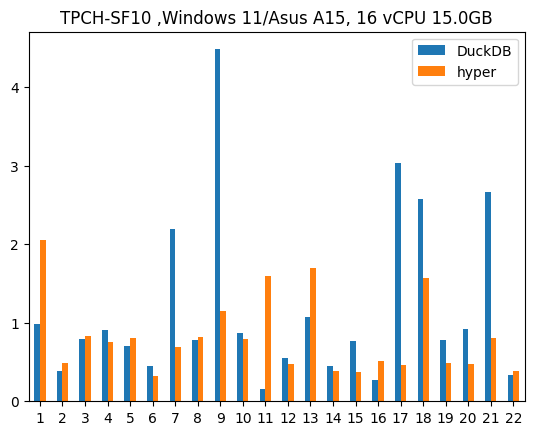

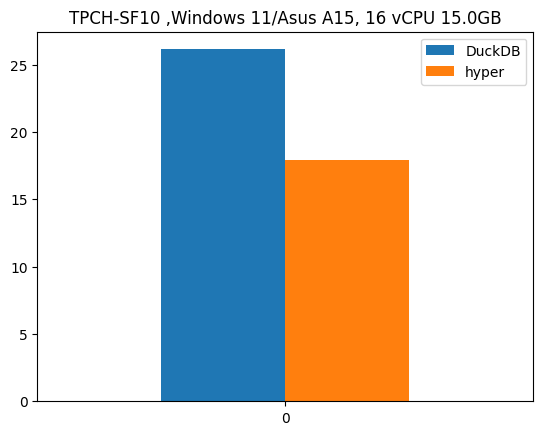

In [19]:
vCPU = str(cpu_count()) + " vCPU"
mem=round(virtual_memory().total/(1024 * 1024 * 1024),0)
runtime = 'TPCH-SF'+str(sf)+' ,Windows 11/Asus A15, '+vCPU+' '+str(mem)+'GB'
hyper['query'] = hyper.index
duck_parquet['query'] = duck_parquet.index
con1=duckdb.connect()
concat = con1.sql('''select  duck_parquet.dur as DuckDB , hyper.dur as hyper from duck_parquet
left join hyper
on duck_parquet.query=hyper.query
''').df()
concat.index = np.arange(1, len(concat)+1)
com = concat.plot.bar(rot=0,title=runtime)
summary= con1.sql(' select round(sum(DuckDB),2) as DuckDB , round(sum(hyper),2) as hyper from concat').df()
sum = summary.plot.bar(rot=0,title= runtime)

In [20]:
con = duckdb.connect(f"./{sf}/TPCH.DUCKDB",read_only=True)
con.execute('''
PRAGMA disable_progress_bar;
-- PRAGMA enable_profiling ;
PRAGMA enable_object_cache
''')
duck_native=run_query(con, sql,'duckdb')
con.close()

Query1
┌──────────────┬──────────────┬───────────────┬───┬────────────────────┬─────────────────────┬─────────────┐
│ l_returnflag │ l_linestatus │    sum_qty    │ … │     avg_price      │      avg_disc       │ count_order │
│   varchar    │   varchar    │ decimal(38,2) │   │       double       │       double        │    int64    │
├──────────────┼──────────────┼───────────────┼───┼────────────────────┼─────────────────────┼─────────────┤
│ A            │ F            │  377518399.00 │ … │  38237.15100895854 │  0.0500065745402432 │    14804077 │
│ N            │ F            │    9851614.00 │ … │  38257.81066008114 │ 0.04997336773765667 │      385998 │
│ N            │ O            │  743124873.00 │ … │  38233.90292348181 │ 0.05000081182113131 │    29144351 │
│ R            │ F            │  377732830.00 │ … │ 38251.219273559764 │ 0.04999679231408742 │    14808183 │
├──────────────┴──────────────┴───────────────┴───┴────────────────────┴─────────────────────┴─────────────┤
│ 4 rows    

C:\Users\kimmo\AppData\Local\Temp\ipykernel_11464\1164121300.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,pd.DataFrame(row, index=[index])], axis=0, ignore_index=True)


┌────────────┬───────────────┬─────────────┬────────────────┐
│ l_orderkey │    revenue    │ o_orderdate │ o_shippriority │
│   int32    │ decimal(38,4) │    date     │     int32      │
├────────────┼───────────────┼─────────────┼────────────────┤
│    4791171 │   440715.2185 │ 1995-02-23  │              0 │
│   46678469 │   439855.3250 │ 1995-01-27  │              0 │
│   23906758 │   432728.5737 │ 1995-03-14  │              0 │
│   23861382 │   428739.1368 │ 1995-03-09  │              0 │
│   59393639 │   426036.0662 │ 1995-02-12  │              0 │
│    3355202 │   425100.6657 │ 1995-03-04  │              0 │
│    9806272 │   425088.0568 │ 1995-03-13  │              0 │
│   22810436 │   423231.9690 │ 1995-01-02  │              0 │
│   16384100 │   421478.7294 │ 1995-03-02  │              0 │
│   52974151 │   415367.1195 │ 1995-02-05  │              0 │
├────────────┴───────────────┴─────────────┴────────────────┤
│ 10 rows                                         4 columns │
└───────

In [21]:
duck_parquet['query'] = duck_parquet.index
duck_native['query'] = duck_native.index
con1=duckdb.connect()
concat = con1.sql('''select  duck_parquet.dur as Parquet,duck_native.dur as Native,round(Parquet/native,1) as ratio  from duck_parquet
left join duck_native
on duck_parquet.query=duck_native.query
''').df()
concat.index = np.arange(1, len(concat)+1)
concat

,Parquet,Native,ratio
1,0.987104,1.228655,0.8
2,0.383594,0.183824,2.1
3,0.789746,0.414513,1.9
4,0.908205,0.961885,0.9
5,0.703509,0.408181,1.7
6,0.443822,0.085774,5.2
7,2.192162,1.198139,1.8
8,0.781849,0.418898,1.9
9,4.484889,3.434921,1.3
10,0.869794,0.834604,1.0


In [22]:
summary= con1.sql(' select round(sum(Parquet),2) as Parquet , round(sum(Native),2) as Native from concat').df()
summary

,Parquet,Native
0,26.13,19.36


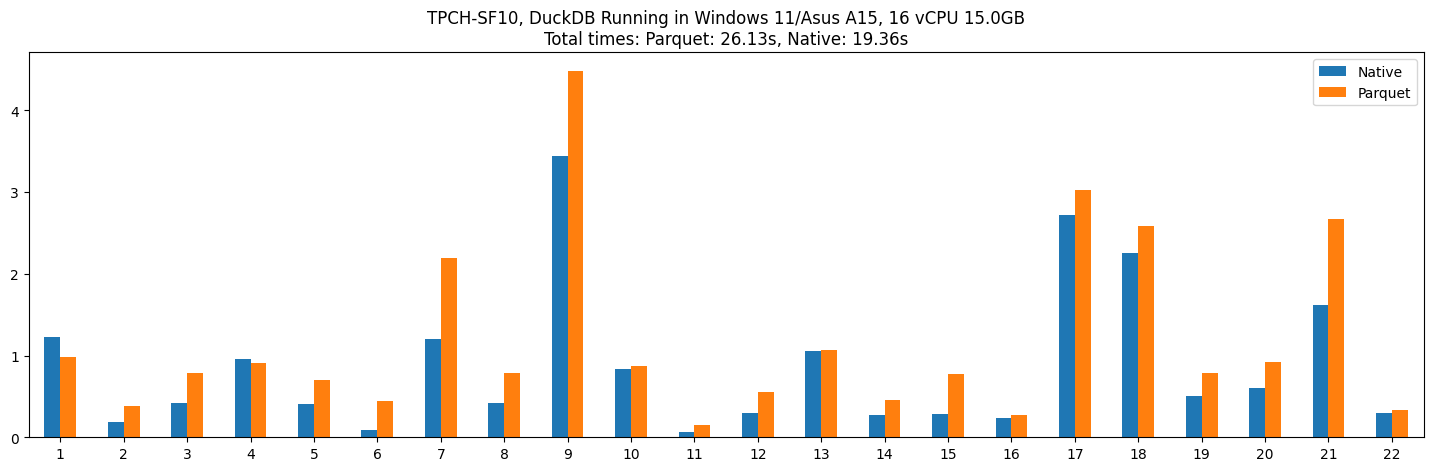

In [23]:
vCPU = str(cpu_count()) + " vCPU"
mem=round(virtual_memory().total/(1024 * 1024 * 1024),0)
runtime = 'TPCH-SF'+str(sf)+', DuckDB Running in Windows 11/Asus A15, '+vCPU+' '+str(mem)+'GB'
runtime += '\nTotal times: Parquet: '+str(summary['Parquet'][0])+'s, Native: '+str(summary['Native'][0])+'s'
ax = concat[['Native','Parquet']].plot.bar(rot=0,title=runtime,figsize=(18,5))